In [1]:
from loader.mnist import MNIST, MNIST_NORMALIZATION
from loader.emnist import EMNIST
from loader.fmnist import FashionMNIST
from core.cnn import simple_cnn
from torchvision import datasets,transforms
import torch
import numpy as np
from core.vos import vos_model
from core.score import plot, plot_confidence_hist, histogram_binning_calibrator
import matplotlib.pyplot as plt

In [2]:
tf = transforms.Compose([
            transforms.ToTensor(),
            MNIST_NORMALIZATION,
        ])
train_data = MNIST('./dataset/',download=True,transform=tf)
test_id = MNIST('./dataset/', download=True,transform=tf,train=False)
val_id = MNIST('./dataset/', download=True,transform=tf,train=True,val=True)
test_near_ood = EMNIST('./dataset/',download=True,transform=tf,train=False,split='letters')
test_far_ood = FashionMNIST('./dataset/',download=True,transform=tf,train=False)

train_loader = torch.utils.data.DataLoader(train_data,batch_size = 128,shuffle=True)
val_id_loader = torch.utils.data.DataLoader(val_id,batch_size = 128,shuffle=False)
test_id_loader = torch.utils.data.DataLoader(test_id,batch_size = 128,shuffle=False)
test_near_ood_loader = torch.utils.data.DataLoader(test_near_ood,batch_size = 128,shuffle=False)
test_far_ood_loader = torch.utils.data.DataLoader(test_far_ood,batch_size = 128,shuffle=False)

In [3]:
model = vos_model(y_dim = 10,h_dims=[32] ).to('cuda:0')
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-4)


/home/rilab/uncertainty/core/vos.py:79: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(self.weight_energy.weight)
/home/rilab/uncertainty/core/vos.py:80: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(self.energy_surface.weight)


In [4]:
class buffer():
    def __init__(self,feature_dim=128, queue_size=100):
        self.queue_size = queue_size
        self.device = 'cuda'
        self.features = torch.zeros((0, feature_dim)).to(self.device)
        self.labels = torch.zeros((0)).to(self.device)
    def append(self, features, labels):
        self.features = torch.cat((self.features, features))
        self.labels = torch.cat((self.labels, labels))
        if self.features.shape[0] > self.queue_size:
            self.features = self.features[-self.queue_size:]
            self.labels = self.labels[-self.queue_size:]
            # print(self.features.shape, self.labels.shape)

    def get_size(self):
        return self.features.shape[0]


In [5]:
from torch.distributions.multivariate_normal import MultivariateNormal
class vos():
    def __init__(self,num_classes, feature_dim = 32, T =1, queue_size = 500):
        self.device = 'cuda'
        self.num_classes = num_classes
        self.feature_dim = feature_dim
        self.mu = torch.zeros((num_classes,feature_dim)).to(self.device)
        self.var = torch.zeros((feature_dim,feature_dim)).to(self.device)
        self.num_outlier = T
        self.memory = buffer(feature_dim, queue_size)

    def fit(self):
        labels = self.memory.labels
        features = self.memory.features
        mean_matrix = torch.zeros_like(features)
        self.epsilons = []
        for c in range(self.num_classes):
            index = torch.where(labels == c)[0]
            data = features[index]
            mu = torch.mean(data,axis=0)
            self.mu[c] = mu
            mean_matrix[index] = mu
        
        var_exp = (features-mean_matrix).unsqueeze(-1) # [N x D x 1]
        var_exp2 = (features-mean_matrix).unsqueeze(1) # [N x D x 1]
        self.var = torch.matmul(var_exp, var_exp2)  + 1e-6*torch.eye(self.feature_dim).to(self.device)
        self.var = (torch.sum(self.var, dim = 0)/ self.var.shape[0])
        
        for c in range(self.num_classes):
            log_probs = []
            m = MultivariateNormal(self.mu[c], self.var)
            for _ in range(100):
                sa = m.sample()
                log_prob = torch.exp(m.log_prob(sa))
                log_probs.append(log_prob.item())
            log_probs = np.asarray(log_probs)
            small_probs = np.sort(log_probs)
            ep = small_probs[:self.num_outlier].mean()
            self.epsilons.append(ep)
        # print(self.epsilons)
        
    def sample(self):
        total_outliers = torch.zeros((0, self.feature_dim))
        for label in range(self.num_classes):
            stotal = 0
            m = MultivariateNormal(self.mu[label], self.var)
            outliers = torch.zeros((self.num_outlier,self.feature_dim))
            while stotal < self.num_outlier:
                sa = m.sample()
                log_prob = torch.exp(m.log_prob(sa))
                if log_prob < self.epsilons[label]:
                    outliers[stotal] = sa
                    stotal += 1
            total_outliers = torch.cat((total_outliers,outliers))
        total_outliers = total_outliers[torch.randperm(total_outliers.shape[0])]
        # print(total_outliers.shape)
        return total_outliers

In [6]:
vos_ = vos(10)

In [7]:
iterations = 0
for e in range(5):
    for image,label in train_loader:
        out, features = model(image.to('cuda'))
        if iterations > 99 and iterations%10==0:
            vos_.memory.append(features, label.to('cuda'))
            if iterations % 100 == 0:
                vos_.fit()
            outliers = vos_.sample()
            out_outlier = model.simple_cnn.head(outliers.to('cuda'))
            out_label = torch.ones((out_outlier.shape[0]), dtype=torch.int64)* -1
            out = torch.cat((out, out_outlier))
            label = torch.cat((label, out_label))
        # print(out.shape, label.shape)
        loss = model.oe_criterion(out,label.to('cuda'))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        iterations += 1
    print(loss)

tensor(1.0960, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7410, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6551, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5444, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5337, device='cuda:0', grad_fn=<AddBackward0>)


### Test

In [12]:
model.eval()
y_true = []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_id_loader:
        out,_ = model(image.to('cuda'))
        _,pred_logit = torch.max(out,dim=-1)
        y_true += (label==pred_logit.cpu()).numpy().tolist()
        num_acc += (label == pred_logit.cpu()).sum().item()
        total += label.shape[0]
print("Accuracy:{}".format(num_acc/total))

Accuracy:0.9789


## Uncertainty

In [14]:
model.eval()
id_score = []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_id_loader:
        out,_ = model(image.to('cuda'))
        en = model.energy(out)
        id_score += en.cpu().numpy().tolist()
id_score = np.asarray(id_score)
print(id_score.mean())

near_ood_score = []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_near_ood_loader:
        out,_ = model(image.to('cuda'))
        en =  model.energy(out)
        near_ood_score += en.cpu().numpy().tolist()
near_ood_score = np.asarray(near_ood_score)
print(near_ood_score.mean())

far_ood_score = []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in test_far_ood_loader:
        out,_ = model(image.to('cuda'))
        en =  model.energy(out)
        far_ood_score += en.cpu().numpy().tolist()
far_ood_score = np.asarray(far_ood_score)
print(far_ood_score.mean())

1.9688264482096536
3.6082942065412107
3.472452524238825


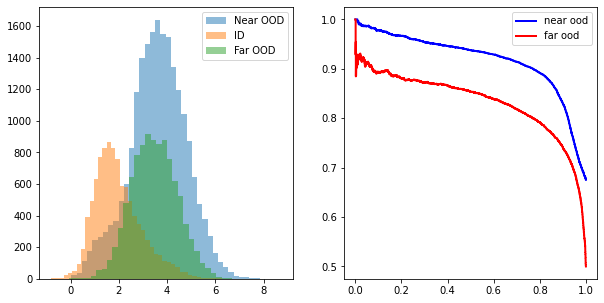

Near AUROC:0.8567146610576922, Far AUROC: 0.86653915


In [15]:
auroc = plot(id_score,near_ood_score,far_ood_score,name='Energy Based',reverse=False)
print("Near AUROC:{}, Far AUROC: {}".format(auroc[0],auroc[1]))

## Calibration

In [26]:
model.eval()
val_y_true,val_score = [], []
with torch.no_grad():
    num_acc = 0
    total = 0
    for image, label in val_id_loader:
        out,_ = model(image.to('cuda'))
        en = model.energy(out)
        _,pred_logit = torch.max(out,dim=-1)
        val_score += en.cpu().numpy().tolist()
        val_y_true += (label==pred_logit.cpu()).numpy().tolist()
        num_acc += (label == pred_logit.cpu()).sum().item()
        total += label.shape[0]
print("Accuracy:{}".format(num_acc/total))
val_score = np.asarray(val_score)[:,0]

Accuracy:0.9826666666666667


In [27]:
val_score.shape

(6000,)

ECE(%):  0.3762984482601064


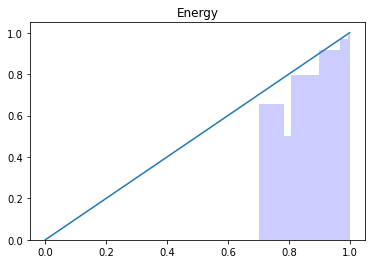

In [29]:
cval_score_en = val_score*-1
cid_score_en = id_score* -1
min_en= cval_score_en.min() -1 
max_en = cval_score_en.max() +1
cal = histogram_binning_calibrator(15,min_en, max_en)
cal.fit(cval_score_en,val_y_true)
prob_pred, prob_true, ece = cal.inference(cid_score_en[:,0], y_true)

plot_confidence_hist(prob_true,prob_pred,'Energy')